In [6]:
from six.moves import cPickle
import os
import matplotlib.pyplot as plt
import numpy as np
import importlib
import utils as ut
import functions as fu 
from tqdm import tqdm

In [7]:
K, d, n = 10, 3072, 10000
np.random.seed(42)
mu, sigma = 0, 0.01 
batch_start, batch_end= 0, 20

# Explore cifar-10 dataset 

(10000, 32, 32, 3)
D:\Logiciel\anaconda\envs\tf-keras-gpu\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


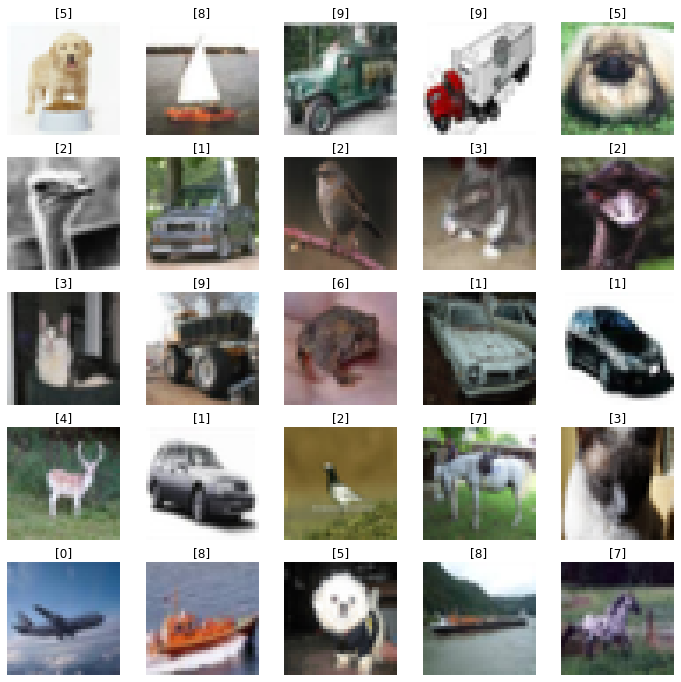

In [5]:
importlib.reload(ut)
X, y, _ = ut.loadData('data_batch_1', reshape=True, clipping=False)
ut.plotCifar(X, y)

# Exercise 1: Trianing a multi-linear classifier

## Data Preprocessing and Loading 

In [8]:
importlib.reload(ut)
X_train, y_train, Y_train = ut.loadData('data_batch_1', clipping=True)
X_val, y_val, Y_val = ut.loadData('data_batch_2', clipping=True)
X_test, y_test, Y_test = ut.loadData('data_batch_3', clipping=True)

## normalize with mean and std of train set 
mean_X = np.mean(X_train, axis=1)
std_X = np.std(X_train, axis=1)

X_train -= np.outer(mean_X, np.ones(X_train.shape[1]))
X_train /= np.outer(std_X, np.ones(X_train.shape[1]))

X_val -= np.outer(mean_X, np.ones(X_val.shape[1]))
X_val /= np.outer(std_X, np.ones(X_val.shape[1]))

X_test -= np.outer(mean_X, np.ones(X_test.shape[1]))
X_test /= np.outer(std_X, np.ones(X_test.shape[1]))

In [6]:
X_train.shape

(3072, 10000)

In [7]:
Y_train.shape

(10, 10000)

In [8]:
mean_X.shape

(3072,)

## Steps check

In [11]:
importlib.reload(ut)
P = ut.EvaluateClassifier(X_train[:, :100], W, b)
print(P.shape)
print(np.argmax(P, axis=0))

(10, 100)
[1 7 9 3 4 8 2 1 6 8 1 6 6 1 7 9 8 8 6 0 5 8 8 4 4 7 8 8 9 6 9 8 1 1 7 4 6
 7 1 1 3 5 5 3 9 1 2 7 6 6 0 8 4 6 7 5 4 7 1 8 9 2 9 8 2 6 1 6 8 6 4 0 0 8
 6 9 6 9 3 5 0 8 1 3 7 8 5 1 8 2 6 8 6 8 6 4 9 8 8 8]


In [13]:
importlib.reload(ut)
cost = ut.ComputeCost(X_train[:,:100], Y_train[:, :100], W , b, 1e-2)
cost

2.3803563016775207

In [14]:
acc = ut.ComputeAccuracy(X_train[:, :100], y_train[:100], W, b)
acc

0.08

## Analytical vs Numerical Gradients

In [9]:
importlib.reload(fu)
batch_size = [1, 32, 64, 100]
lambdas = [0, 0.1, 1]
np.random.seed(42)
for bs in tqdm(batch_size):
    for l in lambdas:
        W = np.random.normal(mu, sigma, (K,d))
        b = np.random.normal(mu, sigma, (K,1))
        P = ut.EvaluateClassifier(X_train[:, :bs], W, b)
        ga_w, ga_b = ut.ComputeGradients(X_train[:, :bs], Y_train[:, :bs], P, W, l)
        ga_b = ga_b.reshape(-1,1)
        gn_w, gn_b = fu.ComputeGradsNumSlow(X_train[:, :bs], Y_train[:, :bs], W, b, l, 1e-6)
        gn_b = gn_b.reshape(-1,1)
        diff_w = np.mean(abs(gn_w - ga_w))
        diff_b = np.mean(abs(gn_b - ga_b))
        rerr_w = np.mean(ut.compare_gradients(ga_w, gn_w, eps=1e-6))
        rerr_b = np.mean(ut.compare_gradients(ga_b, gn_b, eps=1e-6))
        print(f"{bs}-{l}-> \n diff_w {diff_w} \n diff_b  {diff_b} \n rerr_w {rerr_w} \n rerr_b {rerr_b}")

  0%|          | 0/4 [00:00<?, ?it/s]1-0-> 
 diff_w 8.379684469235016e-11 
 diff_b  7.824231401665216e-11 
 rerr_w 2.4677825568310836e-09 
 rerr_b 4.086813827242692e-10
1-0.1-> 
 diff_w 1.2170887066236448e-10 
 diff_b  8.422527952856029e-11 
 rerr_w 7.425995299087505e-09 
 rerr_b 4.965638268107124e-10
 25%|██▌       | 1/4 [00:22<01:07, 22.53s/it]1-1-> 
 diff_w 2.6185674073256027e-10 
 diff_b  1.5925558372043013e-10 
 rerr_w 9.930073452484776e-09 
 rerr_b 8.670322018039604e-10
32-0-> 
 diff_w 1.1552972385293884e-10 
 diff_b  9.133444348052855e-11 
 rerr_w 7.365010811436585e-09 
 rerr_b 4.9580249970139485e-09
32-0.1-> 
 diff_w 1.4266791969390815e-10 
 diff_b  1.584991610181774e-10 
 rerr_w 1.0098538974048592e-08 
 rerr_b 3.856275265425341e-09
 50%|█████     | 2/4 [01:39<01:49, 54.79s/it]32-1-> 
 diff_w 2.8664280143955743e-10 
 diff_b  1.3968159372212962e-10 
 rerr_w 1.8568337156929052e-08 
 rerr_b 2.1272634438002443e-09
64-0-> 
 diff_w 1.1791906577335878e-10 
 diff_b  1.1901635944139287e

## MiniBatch Train

In [19]:
importlib.reload(ut)

W = np.random.normal(mu, sigma, (K,d))
b = np.random.normal(mu, sigma, (K,1))
GDparams = {"n_batch":100, "n_epochs":40, "eta":1e-3, "lambda":0}
W, b, train_loss, val_loss, train_acc, val_acc = ut.minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, GDparams, W, b, verbose=True)

100%|██████████| 40/40 [02:03<00:00,  3.09s/it]Epoch 39: train_acc=0.4567 | val_acc=0.3872 | train_loss=1.6109912671311675 | val_loss=1.7881834884250198



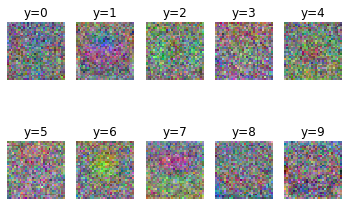

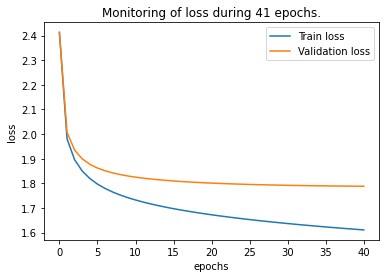

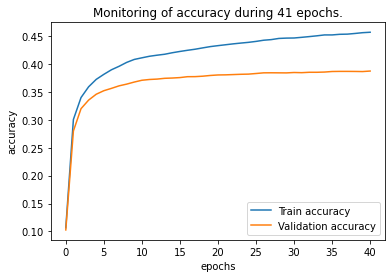

In [20]:
importlib.reload(ut)
ut.montage(W, GDparams)
ut.plot_metric(train_loss, val_loss, GDparams, type="loss")
ut.plot_metric(train_acc, val_acc, GDparams, type="accuracy")

## Experiments

100%|██████████| 40/40 [02:13<00:00,  3.33s/it]


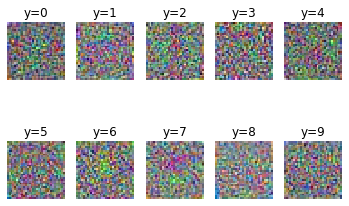

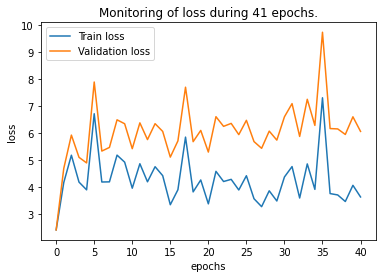

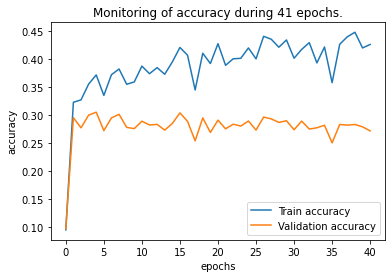

100%|██████████| 40/40 [02:14<00:00,  3.35s/it]


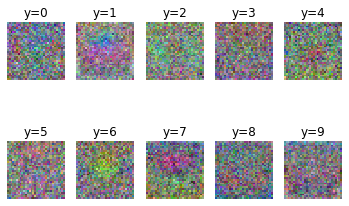

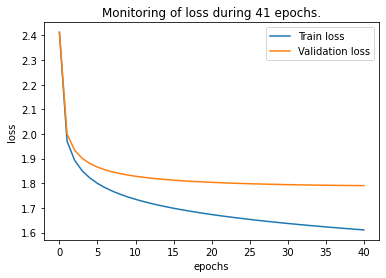

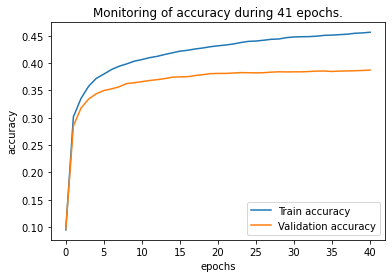

100%|██████████| 40/40 [02:05<00:00,  3.15s/it]


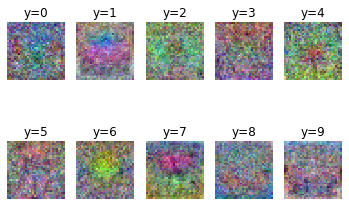

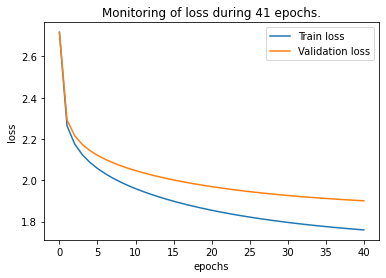

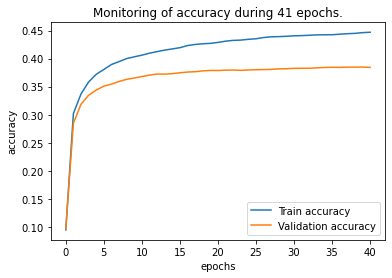

100%|██████████| 40/40 [01:56<00:00,  2.90s/it]


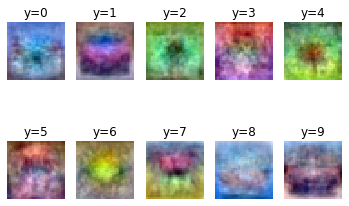

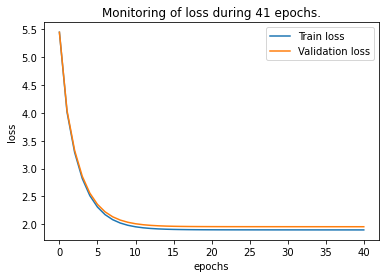

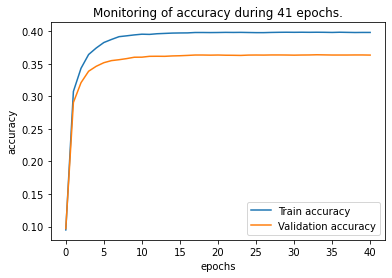

In [10]:
importlib.reload(ut)

GDparams = [{"lambda":0, "n_epochs":40, "n_batch":100, "eta":.1}, {"lambda":0, "n_epochs":40, "n_batch":100, "eta":.001}, 
          {"lambda":.1, "n_epochs":40, "n_batch":100, "eta":.001}, {"lambda":1, "n_epochs":40, "n_batch":100, "eta":.001}]

np.random.seed(42)
seeds = np.random.randint(0, 100, 5)
stats = {i:{"val_loss":[], "train_loss":[], "val_acc":[], "train_acc":[], "test_acc":[]}for i in range(4)}

for i, GDparam in enumerate(GDparams): 
    for seed in seeds:
        np.random.seed(seed)
        W = np.random.normal(mu, sigma, (K,d))
        b = np.random.normal(mu, sigma, (K,1))
        W, b, train_loss, val_loss, train_acc, val_acc = ut.minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, GDparam, W, b, verbose=False)

        stats[i]["train_loss"].append(train_loss[-1])
        stats[i]["val_loss"].append(val_loss[-1])
        stats[i]["train_acc"].append(train_acc[-1])
        stats[i]["val_acc"].append(val_acc[-1])
        stats[i]["test_acc"].append(ut.ComputeAccuracy(X_test, y_test, W, b))
    
    ut.montage(W, GDparam)
    ut.plot_metric(train_loss, val_loss, GDparam, type="loss", experiment="mandatory")
    ut.plot_metric(train_acc, val_acc, GDparam, type="accuracy", experiment="mandatory")
np.save("History/mandatory_stats.npy", stats)

In [11]:
for i in range(4):
    stats[i]['stats_val_acc'] = [round(np.mean(stats[i]['val_acc']),5), round(np.std(stats[i]['val_acc']),5)]
    stats[i]['stats_train_acc'] = [round(np.mean(stats[i]['train_acc']),5), round(np.std(stats[i]['train_acc']),5)]
    stats[i]['stats_test_acc'] = [round(np.mean(stats[i]['test_acc']),5), round(np.std(stats[i]['test_acc']),5)]
    stats[i]['stats_val_loss'] = [round(np.mean(stats[i]['val_loss']),5), round(np.std(stats[i]['val_loss']),5)]
    stats[i]['stats_train_loss'] = [round(np.mean(stats[i]['train_loss']),5), round(np.std(stats[i]['train_loss']),5)]

    print(f"Conf {i} -> val_acc: {stats[i]['stats_val_acc']} train_acc: {stats[i]['stats_train_acc']} test_acc: {stats[i]['stats_test_acc']}  val_loss: {stats[i]['stats_val_loss']}train_loss: {stats[i]['stats_train_loss']}")

np.save("History/stats.npy", stats)

Conf 0 -> val_acc: [0.28032, 0.00476] train_acc: [0.43448, 0.00891] test_acc: [0.29096, 0.00394]  val_loss: [6.23582, 0.31703]train_loss: [3.73644, 0.28717]
Conf 1 -> val_acc: [0.3848, 0.00132] train_acc: [0.45672, 0.00127] test_acc: [0.39348, 0.00084]  val_loss: [1.79089, 0.00085]train_loss: [1.61084, 0.00144]
Conf 2 -> val_acc: [0.3863, 0.00114] train_acc: [0.44684, 0.00143] test_acc: [0.39634, 0.00147]  val_loss: [1.90145, 0.00089]train_loss: [1.76023, 0.00049]
Conf 3 -> val_acc: [0.36346, 0.00034] train_acc: [0.39894, 0.00058] test_acc: [0.37938, 0.0003]  val_loss: [1.95688, 0.00021]train_loss: [1.89973, 0.00019]


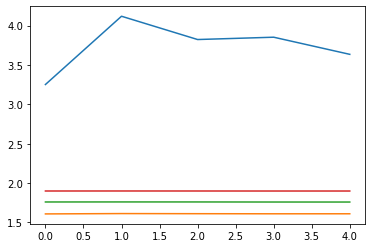

In [14]:
for i in range(4):
    plt.plot(stats[i]['train_loss'])
plt.show()